(multilevel_hgf)=
# Multilevel embeding of Hierarchical Gaussian Filters

In [8]:
from numpy import loadtxt
import numpy as np
from ghgf.distribution import hgf_logp, HGFDistribution
from ghgf import load_data
from ghgf.response import binary_surprise
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

In the previous tutorials, we interoduced the binary and continuous Hierarchical Gaussian Filters (HGF) with 2 or 3 levels of volatility. Those models are operating at the agent level (i.e. the observations and the parameters being estimated are the observations and the parameters of one agent operating in the environment). However, mode concret use cases of the HGF could require to make inference at the group-level (e.g. comparing the hyper-parameters of different group of participants undergoing the same task). Such example are standard practice in Bayesian cognitive modelling {cite:p}`2014:lee` and require to embede the fitting of HGF model in a Bayesian networks. This is partially what we have been doing in the previous tutorials when we estimated the model's parameters using MCMC sampling. Here, we are going to extend this principle and and fit many models (i.e. many participant) at a time and estimate both parameters and hyper-parameters posterior densities.

```{note} Automatic broadcasting of model parameters
Estimating group-level parameters in the context of a graphical probabilistic model require to fit multiple models at the same time, either on different input data, or on the same data with different parameters, or on different datasets with different parameters. This steps is handled natively both by the `:py:class:ghgf.distribution.hgf_logp` class and the `:py:class:ghgf.distribution.HGFDistribution` class through an automated [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) approach. When a list of *n* input time series is provided, the function will automatically apply *n* models using the provided parameters. If for some parameters an array of length *n* is provided, each model will use the n-th value as parameter.
```

## Continuous HGF
### Simulate a dataset

In [9]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1

    for i in range(100):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(input_data)

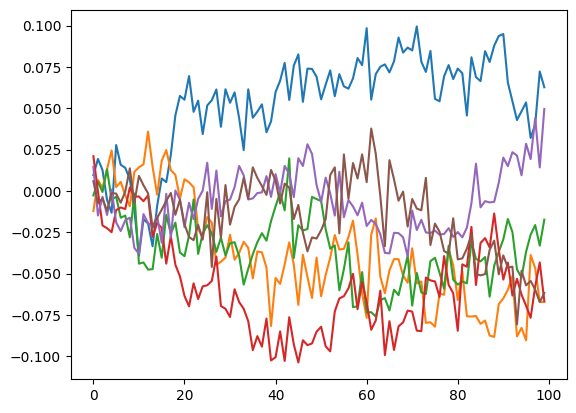

In [10]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the group-level value of the `omega_1` parameter. The dataset consist in 3 time series derived from the classic USD-SWF conversion rate example. Every time series will be fitted to an HGF model where the `omega_1` parameter has to be estimated and the other parameters are fixed.

In [4]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [5]:
with pm.Model() as model:
    
    # Hypterpriors
    #-------------
    #mu_omega_1 = pm.Normal("mu_omega_1", mu=.0, sigma=1.0)
    #sigma_omega_1 = pm.Uniform("sigma_omega_1", .5, 10)
    
    # Priors
    #-------
    #normal_dist = pm.Normal.dist(mu=-5, sigma=2, shape=n_data)
    #omega_2 = pm.Censored("omega_2", normal_dist, lower=-20.0, upper=0.0, shape=n_data)
    #omega_1 = pm.Normal("omega_1", mu=mu_omega_1, sigma=sigma_omega_1, shape=n_data)
    omega_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)
    #omega_1 = pm.Deterministic("omega_1", norm * sigma_omega_1 + mu_omega_1)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

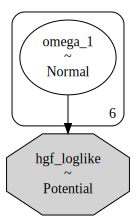

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_1]



KeyboardInterrupt



In [ ]:
az.plot_trace(idata);
plt.tight_layout()

In [ ]:
az.summary(idata)

## Binary HGF

### Simulate a dataset

In [117]:
n_data = 10
dataset = []
for participant in range(n_data):
    input_data = []
    omega_2 = -1.0
    mu_2 = -1.0

    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)
        if mu_2%100 == 0:
            mu_2 = 1.0 if mu_2/100%2 else -1.0

        # x1
        s2 = 1/(1+np.exp(-mu_2))  # sigmoid function
        u = np.random.binomial(n=1, p=s2)       
        input_data.append(u)

    dataset.append(input_data)

### Without hyper-priors

In [118]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=dataset,
    response_function=binary_surprise,
)

In [119]:
with pm.Model() as two_levels_binary_hgf:

    omega_2 = pm.Uniform("omega_2", -5.0, 0.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.nan,
            omega_2=omega_2,
            omega_input=jnp.nan,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.nan,
            mu_2=0.0,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

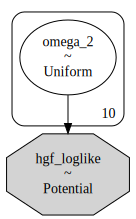

In [120]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [121]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

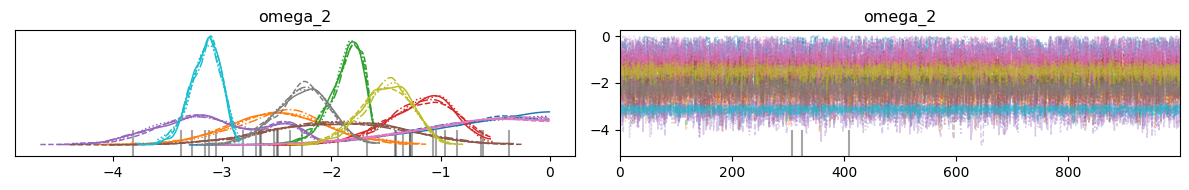

In [122]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()

In [123]:
az.summary(two_level_hgf_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_2[0],-0.771,0.559,-1.762,-0.001,0.009,0.007,2555.0,1419.0,1.0
omega_2[1],-2.479,0.456,-3.308,-1.553,0.008,0.006,3172.0,2295.0,1.0
omega_2[2],-1.866,0.156,-2.166,-1.631,0.003,0.002,2619.0,1962.0,1.0
omega_2[3],-1.188,0.316,-1.780,-0.643,0.006,0.004,3433.0,2850.0,1.0
omega_2[4],-3.054,0.495,-3.903,-2.221,0.012,0.008,2071.0,2551.0,1.0
omega_2[5],-1.959,0.609,-3.118,-0.852,0.010,0.007,3756.0,2387.0,1.0
omega_2[6],-0.797,0.558,-1.802,-0.002,0.009,0.006,2888.0,1854.0,1.0
omega_2[7],-2.264,0.252,-2.752,-1.813,0.005,0.003,3186.0,2305.0,1.0
omega_2[8],-1.503,0.234,-1.943,-1.080,0.004,0.003,2897.0,2760.0,1.0
omega_2[9],-3.154,0.141,-3.407,-2.901,0.003,0.002,2848.0,1814.0,1.0


### With hyper-priors

In [17]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=data,
    response_function=binary_surprise,
)

In [18]:
with pm.Model() as two_levels_binary_hgf:

    # hyper-parameters
    mu_omega = pm.Uniform("mu_omega", -3.0, 0.0)
    sigma_omega = pm.Uniform("sigma_omega", .2, 10.0)
    
    # parameters
    omega_2 = pm.Normal("omega_2", mu_omega, sigma_omega, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.nan,
            omega_2=omega_2,
            omega_input=jnp.nan,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.nan,
            mu_2=0.5,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

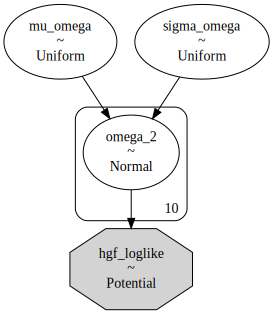

In [19]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [20]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

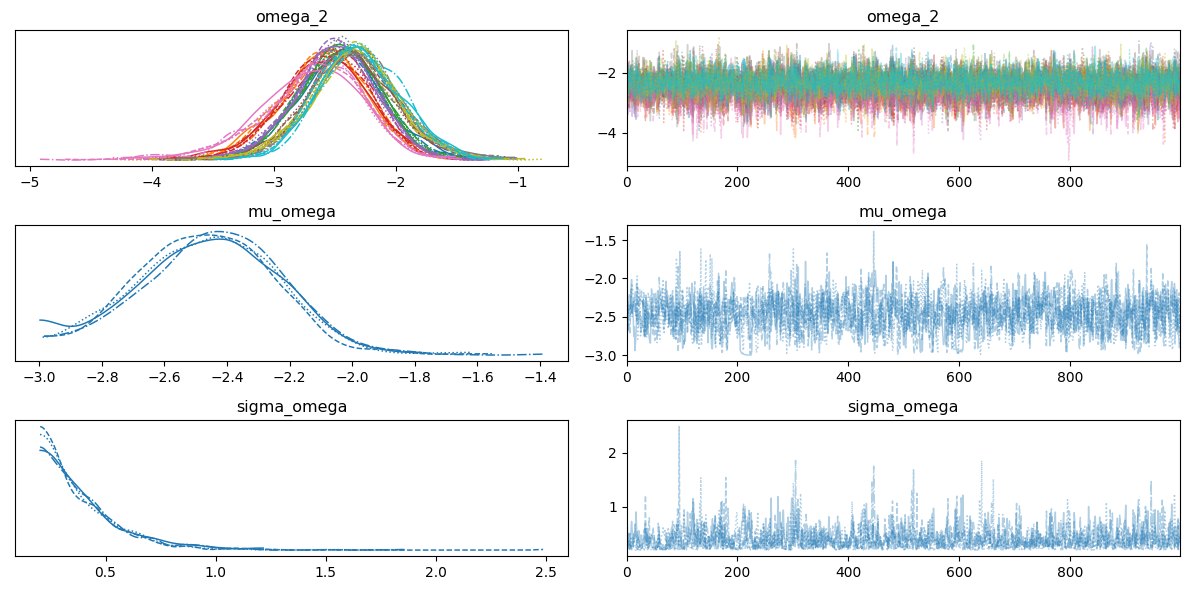

In [21]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()

In [22]:
az.summary(two_level_hgf_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_2[0],-2.463,0.356,-3.154,-1.807,0.007,0.005,2269.0,1960.0,1.0
omega_2[1],-2.594,0.369,-3.327,-1.943,0.008,0.005,2383.0,2859.0,1.0
omega_2[2],-2.467,0.341,-3.124,-1.861,0.007,0.005,2328.0,2764.0,1.0
omega_2[3],-2.575,0.365,-3.210,-1.871,0.008,0.006,2354.0,2279.0,1.0
omega_2[4],-2.500,0.345,-3.172,-1.891,0.007,0.005,2542.0,2687.0,1.0
omega_2[5],-2.367,0.362,-3.058,-1.680,0.007,0.005,2692.0,2291.0,1.0
omega_2[6],-2.687,0.424,-3.489,-1.929,0.010,0.007,1866.0,1915.0,1.0
omega_2[7],-2.329,0.365,-3.004,-1.626,0.008,0.006,2092.0,2492.0,1.0
omega_2[8],-2.345,0.364,-3.002,-1.603,0.007,0.005,2476.0,2178.0,1.0
omega_2[9],-2.303,0.334,-2.918,-1.668,0.007,0.005,2508.0,2651.0,1.0
